In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR

import lightning as L
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor

from wandb import wandb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
N = 16

In [3]:
# Load data (parquet)
df = pd.read_parquet("../sho.parquet")
df

,omega,a,s,v0,dv0,v1,dv1,v2,dv2,v3,...,v11,dv11,v12,dv12,v13,dv13,v14,dv14,v15,dv15
0,0.730015,0.465831,-0.688822,0.057822,-0.340064,0.042456,-0.291396,0.029459,-0.242729,0.018830,...,0.019067,0.195280,0.029755,0.243948,0.042812,0.292616,0.058237,0.341284,0.076031,0.389951
1,0.942236,0.610079,-1.604125,0.165220,-0.574838,0.131084,-0.512023,0.100893,-0.449207,0.074649,...,0.006744,0.116135,0.016012,0.178951,0.029226,0.241766,0.046385,0.304582,0.067491,0.367398
2,0.656625,0.607784,-0.640249,0.079635,-0.399086,0.063123,-0.355311,0.048527,-0.311536,0.035848,...,0.003398,0.082439,0.007965,0.126214,0.014448,0.169989,0.022847,0.213764,0.033163,0.257539
3,0.397185,0.144954,-0.109114,0.001657,-0.057574,0.000483,-0.031095,0.000011,-0.004616,0.000239,...,0.027307,0.233695,0.033845,0.260174,0.041085,0.286653,0.049026,0.313132,0.057668,0.339611
4,0.350593,0.112360,-0.079288,0.000776,-0.039393,0.000128,-0.016020,0.000027,0.007353,0.000472,...,0.023699,0.217709,0.029060,0.241082,0.034968,0.264455,0.041422,0.287828,0.048423,0.311201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.717983,0.633164,-0.814009,0.103331,-0.454601,0.082717,-0.406735,0.064394,-0.358870,0.048362,...,0.002586,0.071920,0.007174,0.119785,0.014053,0.167651,0.023224,0.215517,0.034685,0.263382
9996,1.024487,0.385159,-1.569259,0.077851,-0.394591,0.053233,-0.326292,0.033280,-0.257992,0.017992,...,0.063617,0.356700,0.090312,0.424999,0.121671,0.493298,0.157696,0.561597,0.198385,0.629896
9997,0.800453,0.256945,-0.645574,0.021151,-0.205672,0.011599,-0.152309,0.004895,-0.098945,0.001039,...,0.072705,0.381327,0.094478,0.434691,0.119098,0.488054,0.146567,0.541418,0.176882,0.594781
9998,0.110174,0.632927,-0.016239,0.002431,-0.069732,0.001946,-0.062387,0.001515,-0.055042,0.001138,...,0.000061,0.011062,0.000169,0.018407,0.000332,0.025752,0.000548,0.033097,0.000818,0.040442


In [4]:
omega = df["omega"].values
a     = df["a"].values
s     = df["s"].values

In [5]:
vs = []
dvs = []
for i in range(N):
    vs.append(df[f"v{i}"].values)
    dvs.append(df[f"dv{i}"].values)
vs = np.array(vs).T
dvs = np.array(dvs).T

In [6]:
vs.shape

(10000, 16)

In [20]:
vs_new = vs.reshape(-1, N, 1)
dvs_new = dvs.reshape(-1, N, 1)

np.concatenate([vs_new, dvs_new], axis=2).shape

(10000, 16, 2)

In [21]:
s_min = s.min()
s_max = s.max()
s = (s - s_min) / (s_max - s_min)

In [22]:
class SHO(Dataset):
    def __init__(self, vs, dvs, omega, a, s):
        self.omega = omega.astype(np.float32)
        self.a     = a.astype(np.float32)
        self.s     = s.astype(np.float32)

        vs_new = vs.astype(np.float32).reshape(-1, N, 1)
        dvs_new = dvs.astype(np.float32).reshape(-1, N, 1)
        self.X = np.concatenate([vs_new, dvs_new], axis=2)
        self.y = self.s

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.omega[idx], self.a[idx]

In [23]:
ds = SHO(vs, dvs, omega, a, s)

In [24]:
ds[0:1][0].shape

(1, 16, 2)

In [25]:
# Split data
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = random_split(ds, [train_size, test_size])

# Create dataloaders
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [26]:
class RNN(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.n_in       = hparams["n_in"]
        self.n_out      = hparams["n_out"]
        self.n_hidden   = hparams["n_hidden"]
        self.n_layers   = hparams["n_layers"]
        self.lr         = hparams["lr"]
        self.epochs     = hparams["epochs"]
        self.batchsize  = hparams["batchsize"]

        # Encoder
        self.encoder = nn.LSTM(self.n_in, self.n_hidden, 1, batch_first=True)
        
        # Decoder
        fc_list = []
        for _ in range(self.n_layers):
            fc_list.append(nn.Linear(self.n_hidden, self.n_hidden))
            fc_list.append(nn.ReLU())
        fc_list.append(nn.Linear(self.n_hidden, self.n_out))
        self.fc = nn.Sequential(*fc_list)

    def forward(self, x):
        _, W, _ = x.shape
        # For each window, encode the sequence
        _, (h, c) = self.encoder(x[:, 0, :].unsqueeze(1))
        for i in range(1, W):
            _, (h, c) = self.encoder(x[:, i, :].unsqueeze(1), (h, c))
        
        # hidden state -> (B, H)
        h = h.squeeze(0)

        # Decode the hidden state
        y = self.fc(h)
        return y

    def training_step(self, batch, batch_idx):
        x, s, _, _ = batch
        y = self(x)
        loss = F.mse_loss(y, s)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, s, _, _ = batch
        y = self(x)
        loss = F.mse_loss(y, s)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = OneCycleLR(optimizer, max_lr=self.lr, epochs=self.epochs, steps_per_epoch=len(train_dl) // self.batchsize + 1)
        return {
            'optimizer': optimizer, 
            'lr_scheduler': scheduler, 
            'monitor': 'val_loss',
            'interval': 'epoch',
            'strict': True
        }
    
    def train_dataloader(self):
        return train_dl
    
    def val_dataloader(self):
        return test_dl

In [27]:
hparams = {
    "n_in": 2,
    "n_out": 1,
    "n_hidden": 16,
    "n_layers": 3,
    "lr": 1e-4,
    "epochs": 100,
    "batchsize": batch_size
}

model = RNN(hparams)

In [13]:
# Wandb logger
wandb.init(project="sho")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


In [28]:
# Train
trainer = Trainer(
    max_epochs=hparams["epochs"],
    logger=WandbLogger(),
    callbacks=[LearningRateMonitor(logging_interval='epoch')]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model)

/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:375: Found unsupported keys in the optimizer configuration: {'interval', 'strict'}

  | Name    | Type       | Params
---------------------------------------
0 | encoder | LSTM       | 1.3 K 
1 | fc      | Sequential | 833   
---------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/tmp/ipykernel_35291/4137332742.py:47: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y, s)
/home/xteca/Documents/Project/Research/bounce_simple/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   2%|▏         | 1/63 [00:00<00:06,  9.89it/s, v_num=b419]

/tmp/ipykernel_35291/4137332742.py:40: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y, s)


Epoch 0: 100%|██████████| 63/63 [00:00<00:00, 106.08it/s, v_num=b419]

/tmp/ipykernel_35291/4137332742.py:40: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y, s)


Epoch 1:  21%|██        | 13/63 [00:00<00:00, 132.66it/s, v_num=b419]

/tmp/ipykernel_35291/4137332742.py:47: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y, s)


Epoch 99: 100%|██████████| 63/63 [00:00<00:00, 93.53it/s, v_num=b419] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 63/63 [00:00<00:00, 93.03it/s, v_num=b419]


In [ ]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_loss,███▇▇▇▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█████▇▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
lr-Adam,0.0
train_loss,0.02658
trainer/global_step,6299
val_loss,0.03667


In [ ]:
# Test for V(x) = 0.5 * omega^2 * (x - a)^2 for omega = pi/4, a = 0.5
def V(x, omega, a):
    return 0.5 * omega**2 * (x - a)**2

def dV(x, omega, a):
    return omega**2 * (x - a)

omega = np.pi / 4
a = 0.5
xp = 1

x = np.linspace(0, 1, 16)
v = V(x, omega, a)
dv = dV(x, omega, a)

s = -0.5 * (xp + a)**2 * omega * np.tan(omega) + 0.5 * omega * a**2 * (np.tan(omega) - omega)

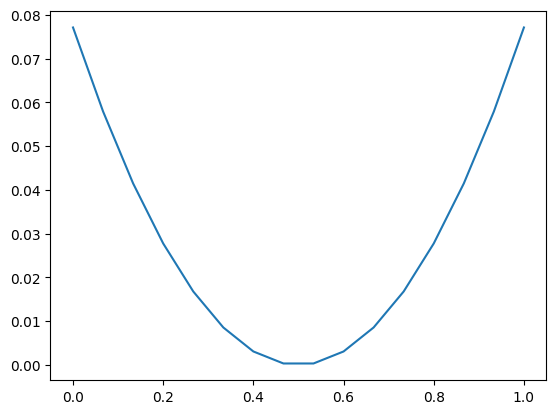

In [ ]:
plt.plot(x, v)
plt.show()

In [ ]:
s

-0.8625044477809588

In [ ]:
# Create test data
vs = v.reshape(1, -1)
dvs = dv.reshape(1, -1)
omega = np.array([omega])
a = np.array([a])
s = np.array([s])

ds_test = SHO(vs, dvs, omega, a, s)
dl_test = DataLoader(ds_test, batch_size=1)

In [ ]:
def s_decode(s):
    return s * (s_max - s_min) + s_min

In [ ]:
model.eval()
for batch in dl_test:
    x, s, omega, a = batch
    y = model(x)
    y = s_decode(y)
    print(y.item(), s.item())

-0.4886786937713623 -0.8625044226646423
